In [58]:
import numpy as np
import matplotlib.pyplot as plt

import tifffile as tf
import os
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [59]:
def nanRobustBlur(I, dim):
    V=I.copy()
    V[I!=I]=0
    VV=cv2.blur(V,dim)   
    W=0*I.copy()+1
    W[I!=I]=0
    WW=cv2.blur(W,dim)    
    Z=VV/WW
    return Z 

In [77]:
anisotropy = cv2.imread('img_retardance3D_t000_p000_z044.tif', -1).astype('float32')
orientation = cv2.imread('img_azimuth_t000_p000_z044.tif', -1).astype('float32')

In [78]:
np.max(anisotropy)

37978.0

In [79]:
anisotropy = anisotropy[100:200, 100:200]
orientation = orientation[100:200, 100:200]

In [80]:
ps = 6.9/63
wavelength = 0.532

orientation = orientation / 18000*np.pi
anisotropy = anisotropy / 10000

In [70]:
def return_smooth(orientation, anisotropy):
    U, V =  anisotropy*np.cos(2 * orientation), anisotropy*np.sin(2 * orientation)
    USmooth = nanRobustBlur(U, (5, 5)) # plot smoothed vector field
    VSmooth = nanRobustBlur(V, (5, 5)) # plot smoothed vector field
    azimuthSmooth = (0.5*np.arctan2(VSmooth,USmooth)) % np.pi
    RSmooth = np.sqrt(USmooth**2+VSmooth**2)
    
    return RSmooth, azimuthSmooth

In [65]:
anisotropy, orientation = return_smooth(orientation, anisotropy)

In [66]:
# # Test
# anisotropy = np.zeros_like(anisotropy) + 3
# orientation = np.zeros_like(orientation) + 0.78539

In [9]:
# def return_D(position):
#     scale_value = anisotropy[position[0]][position[1]]
#     theta = orientation[position[0]][position[1]]
    
#     if scale_value > 1:
#         scale_matrix = np.matrix([[scale_value, 0], [0, scale_value*0.1]])
#     else:
#         scale_matrix = np.matrix([[1, 0], [0, scale_value]])
    
#     angle_matrix = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
#     angle_matrix_2 = np.matrix([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    
#     D_matrix = np.matmul(np.matmul(angle_matrix, scale_matrix), angle_matrix_2)
    
#     return D_matrix

def return_D(position):
    scale_value = anisotropy[position[0]][position[1]]
    theta = orientation[position[0]][position[1]]
    
    if scale_value > 1:
        scale_matrix = np.matrix([[scale_value, 0], [0, 1]])
    else:
        scale_matrix = np.matrix([[1, 0], [0, scale_value]])
    
    angle_matrix = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    angle_matrix_2 = np.matrix([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    
    D_matrix = np.matmul(np.matmul(angle_matrix, scale_matrix), angle_matrix_2)
    
    return D_matrix

In [10]:
D1 = np.zeros_like(anisotropy, dtype=np.float32)
D2 = np.zeros_like(anisotropy, dtype=np.float32)
D3 = np.zeros_like(anisotropy, dtype=np.float32)
D4 = np.zeros_like(anisotropy, dtype=np.float32)

x = np.arange(0, anisotropy.shape[0], 1)
y = np.arange(0, anisotropy.shape[1], 1)

for i in x:
    for j in y:
        scale_matrix = return_D([i, j])

        D1[i, j] = scale_matrix[0, 0]
        D2[i, j] = scale_matrix[0, 1]
        D3[i, j] = scale_matrix[1, 0]
        D4[i, j] = scale_matrix[1, 1]

In [11]:
from scipy import interpolate

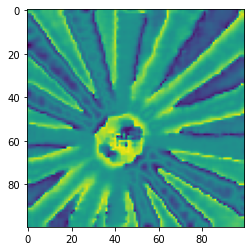

In [84]:
plt.imshow(D3)

In [13]:
D1_interp = interpolate.interp2d(x, y, D1.T, kind='cubic')
D2_interp = interpolate.interp2d(x, y, D2.T, kind='cubic')
D3_interp = interpolate.interp2d(x, y, D3.T, kind='cubic')
D4_interp = interpolate.interp2d(x, y, D4.T, kind='cubic')

In [14]:
def return_D_interp(position):
    D1_value = D1_interp(position[0], position[1])[0]
    D2_value = D2_interp(position[0], position[1])[0]
    D3_value = D3_interp(position[0], position[1])[0]
    D4_value = D4_interp(position[0], position[1])[0]
    
    return np.matrix([[D1_value, D2_value], [D3_value, D4_value]])

In [15]:
D1_int = np.zeros_like(anisotropy, dtype=np.float32)
D2_int = np.zeros_like(anisotropy, dtype=np.float32)
D3_int = np.zeros_like(anisotropy, dtype=np.float32)
D4_int = np.zeros_like(anisotropy, dtype=np.float32)

for i in x:
    for j in y:
        scale_matrix = return_D_interp([i, j])

        D1_int[i, j] = scale_matrix[0, 0]
        D2_int[i, j] = scale_matrix[0, 1]
        D3_int[i, j] = scale_matrix[1, 0]
        D4_int[i, j] = scale_matrix[1, 1]

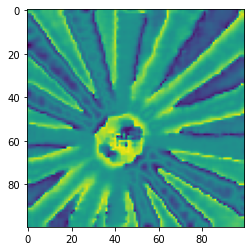

In [16]:
plt.imshow(D2_int)

In [17]:
gamma = 0.5
def force_function(r):
    if 0 < r < 1:
        return r - 1
    elif 1 <= r <= 1 + gamma:
        return ((r-1)*(1+gamma-r)**2)/gamma**2
    elif r > 1 + gamma:
        return 0

In [18]:
def return_D_inverse(pos_a, pos_b):
    D_a = return_D_interp(pos_a)
    D_b = return_D_interp(pos_b)
    
    D_inverse_ab = (np.linalg.inv(D_a) + np.linalg.inv(D_b))/2
    
    return D_inverse_ab

In [19]:
# # Test
# def return_D_inverse(pos_a, pos_b):
#     return np.identity(2, dtype='float32')

# def return_D_interp(position):
#     return np.identity(2, dtype='float32')

In [20]:
alpha = 100
def return_x_ab(pos_a, pos_b):
    D_inv_ab = return_D_inverse(pos_a, pos_b)
    
    pos_a = np.asarray(pos_a, dtype='float32')
    pos_b = np.asarray(pos_b, dtype='float32')
    y_ab = pos_a - pos_b
    y_ab = y_ab.reshape((2, 1))
    
    return D_inv_ab.dot(y_ab)/(2*alpha)

In [21]:
from numpy import linalg as LA
def return_force(pos_a, pos_b):
    x_ab = return_x_ab(pos_a, pos_b)
    x_ab_dist = LA.norm(x_ab)
    D_inv_ab = return_D_inverse(pos_a, pos_b)

    return (-force_function(x_ab_dist)*D_inv_ab.dot(x_ab))/(2*alpha*x_ab_dist)

In [22]:
initial_num_points = 8000
final_points = 2000
random_rows = np.random.choice(anisotropy.shape[0], initial_num_points)
random_columns = np.random.choice(anisotropy.shape[1], initial_num_points)
random_points = list(zip(random_rows, random_columns))

In [23]:
# # Test
# random_points = [(40, 62), (40, 64), (40, 66), (40, 68)]

In [24]:
det_D_list = [np.linalg.det(return_D_interp(pos)) for pos in random_points]
max_det = max(det_D_list)
det_D_list = [x/max_det for x in det_D_list]
points_rejected = np.random.choice(len(random_points), initial_num_points - final_points, det_D_list)
final_points = [random_points[i] for i in range(len(random_points)) if i not in points_rejected]

In [25]:
# final_points = [(40, 64), (40, 66)]

In [26]:
eig_D = [max(np.linalg.eig(return_D_interp(pos))[0]) for pos in random_points]
max_eig = max(eig_D)

In [27]:
# final_points

In [28]:
edge_length = 2*alpha*max_eig*(1+gamma)

def bin_coords(pos):
    x_coord = np.floor(pos[0]/edge_length)
    y_coord = np.floor(pos[1]/edge_length)
    
    return (x_coord, y_coord)

dict_points = {}

for point in final_points:
    bin_coord = bin_coords(point)
    
    if bin_coord in dict_points.keys():
        dict_points[bin_coord].append(point)
    else:
        dict_points[bin_coord] = [point]

In [29]:
def total_force_on_point(index):
    p_a = final_points[index]
    bin_coord = bin_coords(p_a)
    bin_x = bin_coord[0]
    bin_y = bin_coord[1]

    points_cons = []
    points_cons += dict_points[bin_coord]

    if bin_x - 1 >= 0:
        if (bin_x - 1, bin_y) in dict_points.keys():
            points_cons += dict_points[(bin_x - 1, bin_y)]

    if bin_y - 1 >= 0:
        if (bin_x, bin_y - 1) in dict_points.keys():
            points_cons += dict_points[(bin_x, bin_y - 1)]

    if bin_x + 1 < anisotropy.shape[0]:
        if (bin_x + 1, bin_y) in dict_points.keys():
            points_cons += dict_points[(bin_x + 1, bin_y)]

    if bin_y + 1 < anisotropy.shape[1]:
        if (bin_x, bin_y + 1) in dict_points.keys():
            points_cons += dict_points[(bin_x, bin_y + 1)]
    
    total_force = np.zeros((2, 1))

    for point in points_cons:
        if point != p_a:
            f = return_force(p_a, point)
            total_force += f

    return total_force

In [30]:
def diff_equation(y, t, c_drag, total_force):
    p0, p1, r0, r1 = y
    dydt = [r0, r1, total_force[0] - c_drag*r0, total_force[1] - c_drag*r1]
    return dydt

In [31]:
from scipy.integrate import odeint
def solve_particle_path(index):
    c_drag = 50.0
    y0 = [final_points[index][0], final_points[index][1], 0.0, 0.0]
    t = np.linspace(0, 100, 101)
    
    tf = total_force_on_point(index)
    
    sol = odeint(diff_equation, y0, t, args=(c_drag, tf))
    
    return sol

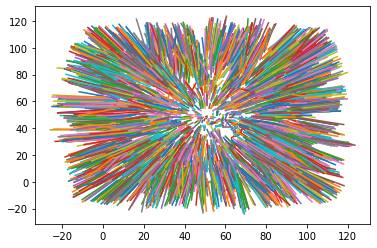

In [32]:
for i in range(len(final_points)):
    sol = solve_particle_path(i)
    plt.plot(sol[:,0], sol[:,1])
#     plt.scatter(sol[-1, 0], sol[-1, 1], s=2)
plt.show()

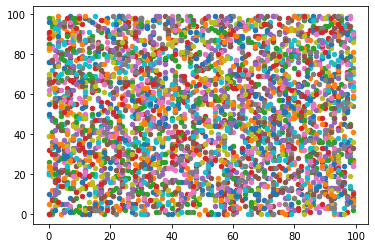

In [33]:
for i in range(len(final_points)):
    plt.scatter(final_points[i][0], final_points[i][1], s=20)

In [34]:
import time

t0 = time.time()
final_positions = []
for i in range(len(final_points)):
    sol = solve_particle_path(i)
    final_positions.append([sol[-1, 0], sol[-1, 1]])
t1 = time.time()
print("Time to execute:", t1-t0)

Time to execute: 9776.755305051804


In [35]:
final_positions = np.array(final_positions)
final_positions = np.around(final_positions, decimals=0)

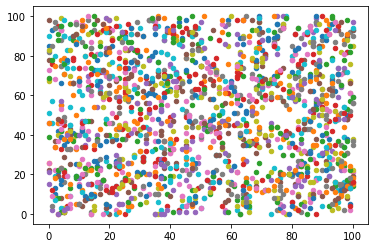

In [36]:
for i in range(len(final_points)):
    if final_positions[i][0] >= 0 and final_positions[i][0] <= anisotropy.shape[0] and final_positions[i][1] >= 0 and final_positions[i][1] <= anisotropy.shape[1]:
        plt.scatter(final_positions[i][0], final_positions[i][1], s=20)

In [48]:
USmooth, VSmooth = anisotropy*np.cos(orientation), anisotropy*np.sin(orientation)
final_positions = final_positions.astype(int)

In [49]:
Plotting_X = []
Plotting_Y = []
Plotting_U = []
Plotting_V = []
Plotting_orient = []

USmooth = USmooth*5
VSmooth = VSmooth*5

for i in range(len(final_positions)):
    if final_positions[i][0] >= 0 and final_positions[i][0] < anisotropy.shape[0] and final_positions[i][1] >= 0 and final_positions[i][1] < anisotropy.shape[1]:
        Plotting_X.append(final_positions[i][0])
        Plotting_Y.append(final_positions[i][1])
        Plotting_U.append(USmooth[final_positions[i][0], final_positions[i][1]])
        Plotting_V.append(VSmooth[final_positions[i][0], final_positions[i][1]])
        Plotting_orient.append(orientation[final_positions[i][0], final_positions[i][1]])     

Plotting_color = Plotting_orient

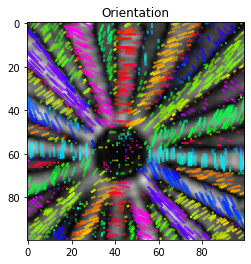

In [50]:
cmapImage = 'gray'
cmapOrient = 'hsv'
linecolor = 'g'
alpha = 0.6
linewidth = 1

im_ax = plt.imshow(anisotropy, cmap=cmapImage)
plt.title('Orientation')
plt.quiver(Plotting_Y, Plotting_X,
           Plotting_U, Plotting_V, Plotting_color,
           cmap=cmapOrient,
           edgecolor=linecolor, facecolor=linecolor, units='xy', alpha=alpha, width=linewidth,
           headwidth=0, headlength=0, headaxislength=0,
           scale_units = 'xy', scale = 1, angles = 'uv', pivot = 'mid')

In [53]:
nY, nX = anisotropy.shape
Y, X = np.mgrid[0:nY,0:nX] # notice the reversed order of X and Y
spacing = 3
    
# Sample variables at the specified spacing.
Plotting_X = X[::spacing, ::spacing]
Plotting_Y = Y[::spacing, ::spacing]
Plotting_U = USmooth[::spacing, ::spacing]
Plotting_V = VSmooth[::spacing, ::spacing]

threshold = np.ones_like(X) # no threshold
Plotting_thres = threshold[::spacing, ::spacing]
Plotting_orient=orientation[::spacing, ::spacing]

thresholdIdx = Plotting_thres==1
Plotting_X=Plotting_X[thresholdIdx]
Plotting_Y=Plotting_Y[thresholdIdx]
Plotting_U=Plotting_U[thresholdIdx]
Plotting_V=Plotting_V[thresholdIdx]
Plotting_orient=Plotting_orient[thresholdIdx]
Plotting_color=Plotting_orient

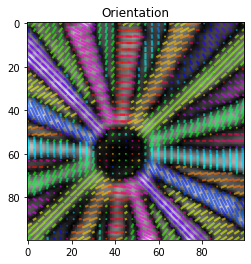

In [54]:
im_ax = plt.imshow(anisotropy, cmap=cmapImage)
plt.title('Orientation')
plt.quiver(Plotting_X, Plotting_Y,
           Plotting_U, Plotting_V, Plotting_color,
           cmap=cmapOrient,
           edgecolor=linecolor, facecolor=linecolor, units='xy', alpha=alpha, width=linewidth,
           headwidth=0, headlength=0, headaxislength=0,
           scale_units = 'xy', scale = 1, angles = 'uv', pivot = 'mid')

In [55]:
USmooth, VSmooth = anisotropy*np.cos(orientation), anisotropy*np.sin(orientation)

Plotting_X = []
Plotting_Y = []
Plotting_U = []
Plotting_V = []
Plotting_orient = []

USmooth = USmooth*5
VSmooth = VSmooth*5

for i in range(len(final_points)):
        Plotting_X.append(final_points[i][0])
        Plotting_Y.append(final_points[i][1])
        Plotting_U.append(USmooth[final_points[i][0], final_points[i][1]])
        Plotting_V.append(VSmooth[final_points[i][0], final_points[i][1]])
        Plotting_orient.append(orientation[final_points[i][0], final_points[i][1]])     

Plotting_color = Plotting_orient

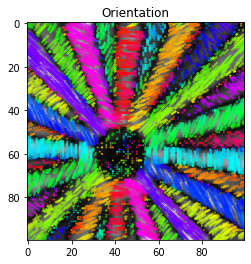

In [56]:
cmapImage = 'gray'
cmapOrient = 'hsv'
linecolor = 'g'
alpha = 0.6
linewidth = 1

im_ax = plt.imshow(anisotropy, cmap=cmapImage)
plt.title('Orientation')
plt.quiver(Plotting_Y, Plotting_X,
           Plotting_U, Plotting_V, Plotting_color,
           cmap=cmapOrient,
           edgecolor=linecolor, facecolor=linecolor, units='xy', alpha=alpha, width=linewidth,
           headwidth=0, headlength=0, headaxislength=0,
           scale_units = 'xy', scale = 1, angles = 'uv', pivot = 'mid')